# Regresión Logística

Implementación de regresión logística para clasificación binaria utilizando método del gradiente

In [1]:
# Importamos las librerías necesarias

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

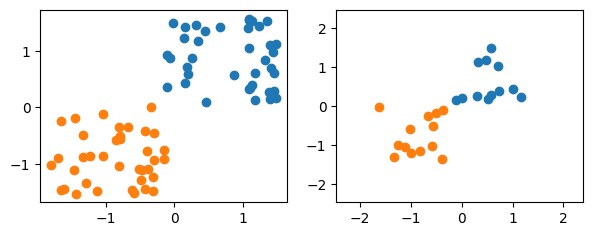

In [14]:
# Delimitamos los datos de prueba y entrenamiento a partir del conjunto de datos RegresionLogistica.txt

data = np.genfromtxt('RegresionLogistica.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]

# normalizamos los datos
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

# Graficamos los datos
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

## Creación del modelo usando la API nn.Module

In [24]:
DISPOSITIVO = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RegresionLogistica(torch.nn.Module):

    def __init__(self, num_caracteristicas):
        super(RegresionLogistica, self).__init__()
        self.perceptron = torch.nn.Linear(num_caracteristicas, 1)

        # Se inicializa el vector de pesos y bias en cero
        self.perceptron.weight.detach().zero_()
        self.perceptron.bias.detach().zero_()

    def forward(self, x):
        logits = self.perceptron(x)
        probas = torch.sigmoid(logits)
        return probas

modelo = RegresionLogistica(num_caracteristicas=2).to(DISPOSITIVO)
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.1)

# Entrenamiento del modelo y exactitud

In [26]:
def exactitud_compilacion(etiquetas_var, pred_probas):
    pred_etiquetas = torch.where((pred_probas > 0.5),
                              torch.tensor([1]),
                              torch.tensor([0])).view(-1)
    exactitud = torch.sum(pred_etiquetas == etiquetas_var.view(-1)).float() / etiquetas_var.size(0)
    return exactitud


num_epocas = 5

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=DISPOSITIVO)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=DISPOSITIVO).view(-1, 1)


for epoca in range(num_epocas):

    #### Calcula las salidas ####
    salida = modelo(X_train_tensor)

    #### Calcula los gradientes ####
    costo = F.binary_cross_entropy(salida, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    costo.backward()

    #### Actualiza los pesos ####
    optimizer.step()

    #### Logging ####
    pred_probas = modelo(X_train_tensor)
    exactitud = exactitud_compilacion(y_train_tensor, pred_probas)
    print('Epoca: %03d' % (epoca + 1), end="")
    print(' | Exactitud del entrenamiento: %.3f' % exactitud, end="")
    print(' | Costo: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))



print('\nParametros del modelo:')
print('  Pesos: %s' % modelo.perceptron.weight)
print('  Bias: %s' % modelo.perceptron.bias)

Epoca: 001 | Exactitud del entrenamiento: 1.000 | Costo: 0.019
Epoca: 002 | Exactitud del entrenamiento: 1.000 | Costo: 0.019
Epoca: 003 | Exactitud del entrenamiento: 1.000 | Costo: 0.018
Epoca: 004 | Exactitud del entrenamiento: 1.000 | Costo: 0.018
Epoca: 005 | Exactitud del entrenamiento: 1.000 | Costo: 0.017

Parametros del modelo:
  Pesos: Parameter containing:
tensor([[3.5601, 3.8335]], requires_grad=True)
  Bias: Parameter containing:
tensor([0.1373], requires_grad=True)


## Evaluando el modelo

In [31]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=DISPOSITIVO)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=DISPOSITIVO)

pred_probas = modelo(X_test_tensor)
exactitud_prueba = exactitud_compilacion(y_test_tensor, pred_probas)

print('Exactitud de la prueba: %.2f%%' % (exactitud_prueba*100))

Exactitud de la prueba: 100.00%


## Graficación del modelo

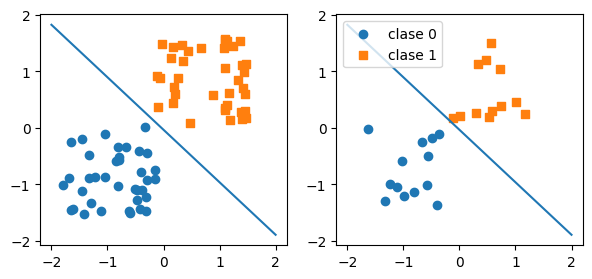

In [36]:
w, b = modelo.perceptron.weight.view(-1), modelo.perceptron.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0])
          / w[1] )
y_min = y_min.detach().numpy()

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0])
          / w[1] )
y_max = y_max.detach().numpy()



fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='clase 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='clase 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='clase 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='clase 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()